In [197]:
import numpy as np
import open3d as o3d
import pathlib
import re
from ipywidgets import interact
from lib.datasets.kitti_utils import Calibration
import cv2
from pathlib import Path
from tools.sample_util import SampleDatabase, merge_labels
from tools.dataset_util import Dataset

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [198]:
test_dir = Path("/mnt/e/DataSet/kitti/kitti_inst_database/test")
np.random.seed(0)


random_flip = 0.5
database = SampleDatabase("/mnt/e/DataSet/kitti/kitti_inst_database/", random_flip=random_flip)
dataset = Dataset("train", r"/mnt/e/DataSet/kitti")

In [199]:
labels_in_all_scenes = []
for idx in range(7481):
    print (idx)
    calib_ = dataset.get_calib(idx)
    image, depth = dataset.get_image_with_depth(idx, use_penet=True)
    ground, non_ground = dataset.get_lidar_with_ground(idx, fov=True)
    plane_ = dataset.get_plane(idx)
    samples = database.get_samples(ground, non_ground, calib_, plane_)
    image_, depth_, samples = database.add_samples_to_scene(samples, image, depth)
    _, _, labels = dataset.get_bbox(idx, chosen_cls=["Car", 'Van', 'Truck', 'DontCare'])
    labels = merge_labels(labels, samples, calib_, image.shape)
    labels_in_all_scenes.append(labels)


0


TypeError: 'NoneType' object is not subscriptable

In [12]:
with open("../data/samples/1.pkl", "wb") as f:
    import pickle
    pickle.dump(labels_in_all_scenes, f)

In [38]:
from matplotlib import pyplot as plt
x, y = [], []

for labels in labels_in_all_scenes:
    for label in labels:
        if label.level_str in ["DontCare", "UnKnown"] or label.cls_type in ['Van', 'Truck', 'DontCare'] :
            continue
        if label.trucation > 0.5 or label.occlusion > 2:
            continue
        # if hasattr(label, "is_fake"):
        #     continue
        height = float(label.box2d[3]) - float(label.box2d[1]) + 1
        # if height < 20:
        #     continue
        
        x.append(label.pos[0])
        y.append(label.pos[2])


(array([4.0000e+00, 7.6000e+01, 5.5500e+02, 3.4820e+03, 1.4415e+04,
        1.4745e+04, 4.1040e+03, 4.8800e+02, 7.1000e+01, 4.0000e+00]),
 array([-44.02999878, -35.64099884, -27.2519989 , -18.86299896,
        -10.47399902,  -2.08499908,   6.30400085,  14.69300079,
         23.08200073,  31.47100067,  39.86000061]),
 <BarContainer object of 10 artists>)

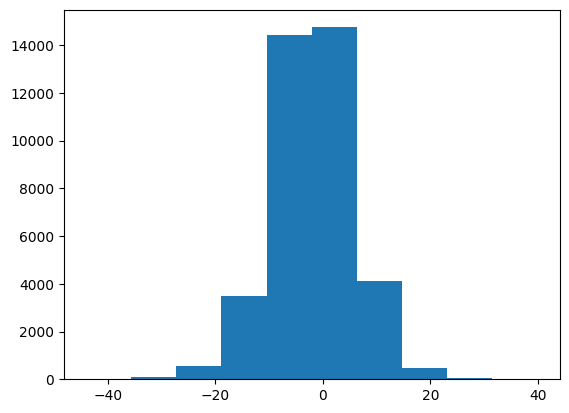

In [41]:
plt.hist(x)

In [134]:
idx = 9

calib_ = dataset.get_calib(idx)
image, depth = dataset.get_image_with_depth(idx, use_penet=True)
ground, non_ground = dataset.get_lidar_with_ground(idx, fov=True)
plane_ = dataset.get_plane(idx)


In [142]:
x, y, z = ground.T
grid_size = 1
x_edges = np.arange(-40, 41, grid_size)
z_edges = np.arange(5, 81, grid_size)
H, _, _ = np.histogram2d(x, z, bins=(x_edges, z_edges))

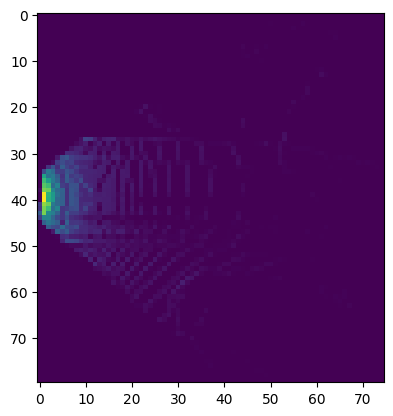

In [143]:
plt.imshow(H)
plt.show()

In [144]:
from tools.visualize_util import show_o3d, plt_show
show_o3d(ground)

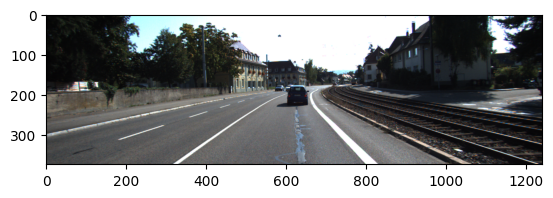

In [145]:
plt_show(image)

In [158]:
from sklearn.decomposition import PCA

grid_size = 1
x_edges = np.arange(-35, 36, grid_size)
z_edges = np.arange(5, 71, grid_size)

plane_database = []

for idx in range(7481):
    all_plane = dict()
    calib_ = dataset.get_calib(idx)
    image, depth = dataset.get_image_with_depth(idx, use_penet=True)
    ground, non_ground = dataset.get_lidar_with_ground(idx, fov=True)
    plane_ = dataset.get_plane(idx)
    print(idx)
    for i, x in enumerate(x_edges):
        for j, z in enumerate(z_edges):
            x += grid_size / 2
            z += grid_size / 2
            y = SampleDatabase.get_y_on_plane(x, z, plane_)
            pos = np.array([x, y, z])
            dis = (x ** 2 + z ** 2) ** 0.5
            radius = dis / 10 if dis / 10 > 2 else 2
            min_num = 10
            
            dis_from_pos = np.linalg.norm(ground - pos, axis=1)
            nearby = ground[dis_from_pos < radius]
            if nearby.shape[0] < min_num:
                continue
            
            pca = PCA(n_components=3)
            pca.fit(nearby)
            normal = pca.components_[2]
            var = pca.explained_variance_ratio_[2]
            if var > 0.5e-2:
                continue
            if not SampleDatabase.check_normal_angle(normal, 20):
                continue
            d = -normal.dot(np.mean(nearby, axis=0))
            plane_in_grid = np.array([*normal, d])
            pos[1] = SampleDatabase.get_y_on_plane(pos[0], pos[2], plane_in_grid)
            all_plane[(x, z)] = {
                "plane": plane_in_grid,
                "radius": radius,
                "point_in_radius": nearby.shape[0],
                "var": var,
                "pos": pos,
                "scene_idx": idx
            }
    plane_database.append(all_plane)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [166]:
for idx in range(7481):
    with open(f"/mnt/e/DataSet/kitti/training/grid_planes/{str(idx).zfill(6)}.pkl", "wb") as f:
        import pickle
        pickle.dump(plane_database[idx], f)

In [167]:
all_plane = plane_database[3900]
cords = []
for (x, z), plane_in_grid in all_plane.items():
    a, b, c, d = plane_in_grid["plane"]
    x_grid = np.arange(- grid_size / 2, grid_size / 2, 0.05) + x
    z_grid = np.arange(- grid_size / 2, grid_size / 2, 0.05) + z
    xx, zz = np.meshgrid(x_grid, z_grid)
    yy = -d - a * xx - c * zz
    yy /= b
    cords.append(np.stack((xx, yy, zz), axis=-1).reshape(-1, 3))
    



In [196]:

for plane_in_grid in [plane_database[1272]]:
    pos2d = np.array([[key[0], key[1]] for key in plane_in_grid.keys() if isinstance(key, tuple)])
    dis = np.linalg.norm(pos2d, axis=-1)
    valid = dis < min(np.max(dis) - 10, 65)
    pos2d = pos2d[valid]
    
    z = pos2d[:, 1]
    a = np.sum((0 > z) & (z >= 0))
    b = np.sum((65 > z) & (z >= 40))
    c = np.sum((40 > z) & (z >= 25))
    d = np.sum((25 > z) & (z >= 10))
    n = a + b + c + d + 1
    print(a / n, b / n , c / n, d / n)
    values = [a, b, c, d]
    labels = ['a', 'b', 'c', 'd']
    plane_in_grid['area'] = labels[values.index(max(values))]
    

0.0 0.0 0.0 0.0


In [193]:

labels = {
    'a':0, 'b':0, 'c':0, 'd':0
}

for i, plane_in_grid in enumerate(plane_database):
    area = plane_in_grid['area']
    if area == 'a':
        print(i)
    labels[area] += 1

print(labels)

1272
3085
3321
3770
4903
6666
7110
{'a': 7, 'b': 3485, 'c': 2082, 'd': 1907}


In [195]:
plane_database[1272]

{(-11.5,
  11.5): {'plane': array([ 0.01190291, -0.9977269 , -0.0663265 ,  2.3409808 ], dtype=float32), 'radius': 2, 'point_in_radius': 58, 'var': 0.0021414328, 'pos': array([-11.5       ,   1.44462632,  11.5       ]), 'scene_idx': 1272},
 (-11.0,
  12.5): {'plane': array([ 0.05339838, -0.9962831 , -0.06758916,  2.77401   ], dtype=float32), 'radius': 2, 'point_in_radius': 141, 'var': 0.003183812, 'pos': array([-11.        ,   1.34676902,  12.5       ]), 'scene_idx': 1272},
 (-10.5,
  13.5): {'plane': array([-0.03982846,  0.9950603 ,  0.09092927, -2.9367158 ], dtype=float32), 'radius': 2, 'point_in_radius': 171, 'var': 0.004030577, 'pos': array([-10.5       ,   1.29738046,  13.5       ]), 'scene_idx': 1272},
 (-10.0,
  14.5): {'plane': array([-0.03330749,  0.99040264,  0.13413936, -3.4513085 ], dtype=float32), 'radius': 2, 'point_in_radius': 141, 'var': 0.0047970396, 'pos': array([-10.        ,   1.18458171,  14.5       ]), 'scene_idx': 1272},
 (-11.0,
  10.5): {'plane': array([ 0.01224